# NLST Demographic Info

Handle the demographic information columns (there's so many) before examining performance.

In [1]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json

import sys
sys.path.append('../')
import utils

## directory where results are
EXPERIMENT_DIR = f"/data/bodyct/experiments/lung-malignancy-fairness-shaurya"
NLST_PREDS = f"{EXPERIMENT_DIR}/nlst-preds"

NLST_PREDS_LOCAL = "/mnt/c/Users/shaur/OneDrive - Radboudumc/Documents - Master - Shaurya Gaur/General/Malignancy-Estimation Results/nlst"
NLST_PREDS = NLST_PREDS_LOCAL ## Comment out if not using Teams backup (aka Chansey is up :)

## Load Demographic Info and Choose Rows Based on Patients

In [2]:
nlst_preds = pd.read_csv(f"{NLST_PREDS}/nlst_kiran_thijmen_pancan_16077.csv")
nlst_preds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16077 entries, 0 to 16076
Data columns (total 26 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   PatientID            16077 non-null  int64  
 1   StudyDate            16077 non-null  int64  
 2   SeriesInstanceUID    16077 non-null  object 
 3   CoordX               16077 non-null  float64
 4   CoordY               16077 non-null  float64
 5   CoordZ               16077 non-null  float64
 6   LesionID             16077 non-null  int64  
 7   NoduleType           16077 non-null  object 
 8   Spiculation          16077 non-null  bool   
 9   Diameter [mm]        16077 non-null  float64
 10  Age                  16077 non-null  int64  
 11  Gender               16077 non-null  int64  
 12  FamilyHistoryLungCa  16077 non-null  bool   
 13  Emphysema            16077 non-null  bool   
 14  NoduleInUpperLung    16077 non-null  bool   
 15  NoduleCounts         16077 non-null 

In [3]:
nlst_dict_full = pd.read_csv(f"{NLST_PREDS}/participant_d040722.csv")
nlst_dict_full.info()

/tmp/ipykernel_4948/2896154133.py:1: DtypeWarning: Columns (239,240,348) have mixed types. Specify dtype option on import or set low_memory=False.
  nlst_dict_full = pd.read_csv(f"{NLST_PREDS}/participant_d040722.csv")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53452 entries, 0 to 53451
Columns: 356 entries, cen to evpsent
dtypes: float64(283), int64(64), object(9)
memory usage: 145.2+ MB


In [4]:
df = nlst_dict_full[nlst_dict_full['pid'].isin(nlst_preds['PatientID'])].reset_index(drop=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5282 entries, 0 to 5281
Columns: 356 entries, cen to evpsent
dtypes: float64(283), int64(64), object(9)
memory usage: 14.3+ MB


## Choose Demographic Columns

In [5]:
cols = {"num": {}, 'cat': {}}
df['PatientID'] = df['pid']
cols["info"] = ['PatientID', 'study']
df['study'].value_counts(dropna=False)

study
1    3518
2    1023
3     741
Name: count, dtype: int64

Next up we analyze and aggregate the columns since that still leaves us about 140 at the end.

### Demographic columns

In [6]:
col_demo_cat = ['race', 'gender', 'ethnic', 'marital', 'educat']
col_demo_num = ['age', 'height', 'weight']
df[col_demo_cat + col_demo_num].isna().sum()

race        0
gender      0
ethnic      0
marital     1
educat      0
age         0
height      9
weight     12
dtype: int64

In [7]:
print(df['educat'].value_counts(dropna=False))
df['educat'].replace([8, 95, 98, 99], value=np.nan, inplace=True)
print(df['educat'].value_counts(dropna=False))

educat
3     1324
5     1201
6      833
7      757
4      711
2      276
8       88
1       81
99      10
95       1
Name: count, dtype: int64
educat
3.0    1324
5.0    1201
6.0     833
7.0     757
4.0     711
2.0     276
NaN      99
1.0      81
Name: count, dtype: int64


In [8]:
print(df['ethnic'].value_counts(dropna=False))
df['ethnic'].replace([7, 95, 98, 99], value=np.nan, inplace=True)
print(df['ethnic'].value_counts(dropna=False))

ethnic
2     5170
1       79
99      29
7        3
95       1
Name: count, dtype: int64
ethnic
2.0    5170
1.0      79
NaN      33
Name: count, dtype: int64


In [9]:
print(df['marital'].value_counts(dropna=False))
df['marital'].replace([7, 9], value=np.nan, inplace=True)
print(df['marital'].value_counts(dropna=False))

marital
2.0    3507
5.0    1014
3.0     454
1.0     233
4.0      62
9.0       6
7.0       5
NaN       1
Name: count, dtype: int64
marital
2.0    3507
5.0    1014
3.0     454
1.0     233
4.0      62
NaN      12
Name: count, dtype: int64


In [ ]:
print(df['race'].value_counts(dropna=False))
df['race'].replace([7, 95, 96, 98, 99], value=np.nan, inplace=True)
print(df['race'].value_counts(dropna=False))

race
1     4882
2      195
3       93
6       59
4       20
5       19
7        6
99       5
98       1
95       1
96       1
Name: count, dtype: int64
race
1.0    4882
2.0     195
3.0      93
6.0      59
4.0      20
5.0      19
NaN      14
Name: count, dtype: int64


In [14]:
df.query('ethnic == 1')['race'].value_counts(dropna=False)

race
1.0    63
NaN     9
2.0     2
6.0     2
3.0     2
4.0     1
Name: count, dtype: int64

In [ ]:
df['NonHispanicWhite'] = (df['race'] == 1.0) & (df['ethnic'] == 2.0)
col_demo_cat.append('NonHispanicWhite')
df['NonHispanicWhite'].value_counts(dropna=False)

In [ ]:
df['HighSchoolPlus'] = (df['educat'] != 1.0)
col_demo_cat.append('HighSchoolPlus')
df['HighSchoolPlus'].value_counts(dropna=False)

In [ ]:
df['Married'] = (df['marital'] == 2.0)
col_demo_cat.append('Married')
df['Married'].value_counts(dropna=False)

In [11]:
df[col_demo_cat + col_demo_num].isna().sum()

race       14
gender      0
ethnic     33
marital    12
educat     99
age         0
height      9
weight     12
dtype: int64

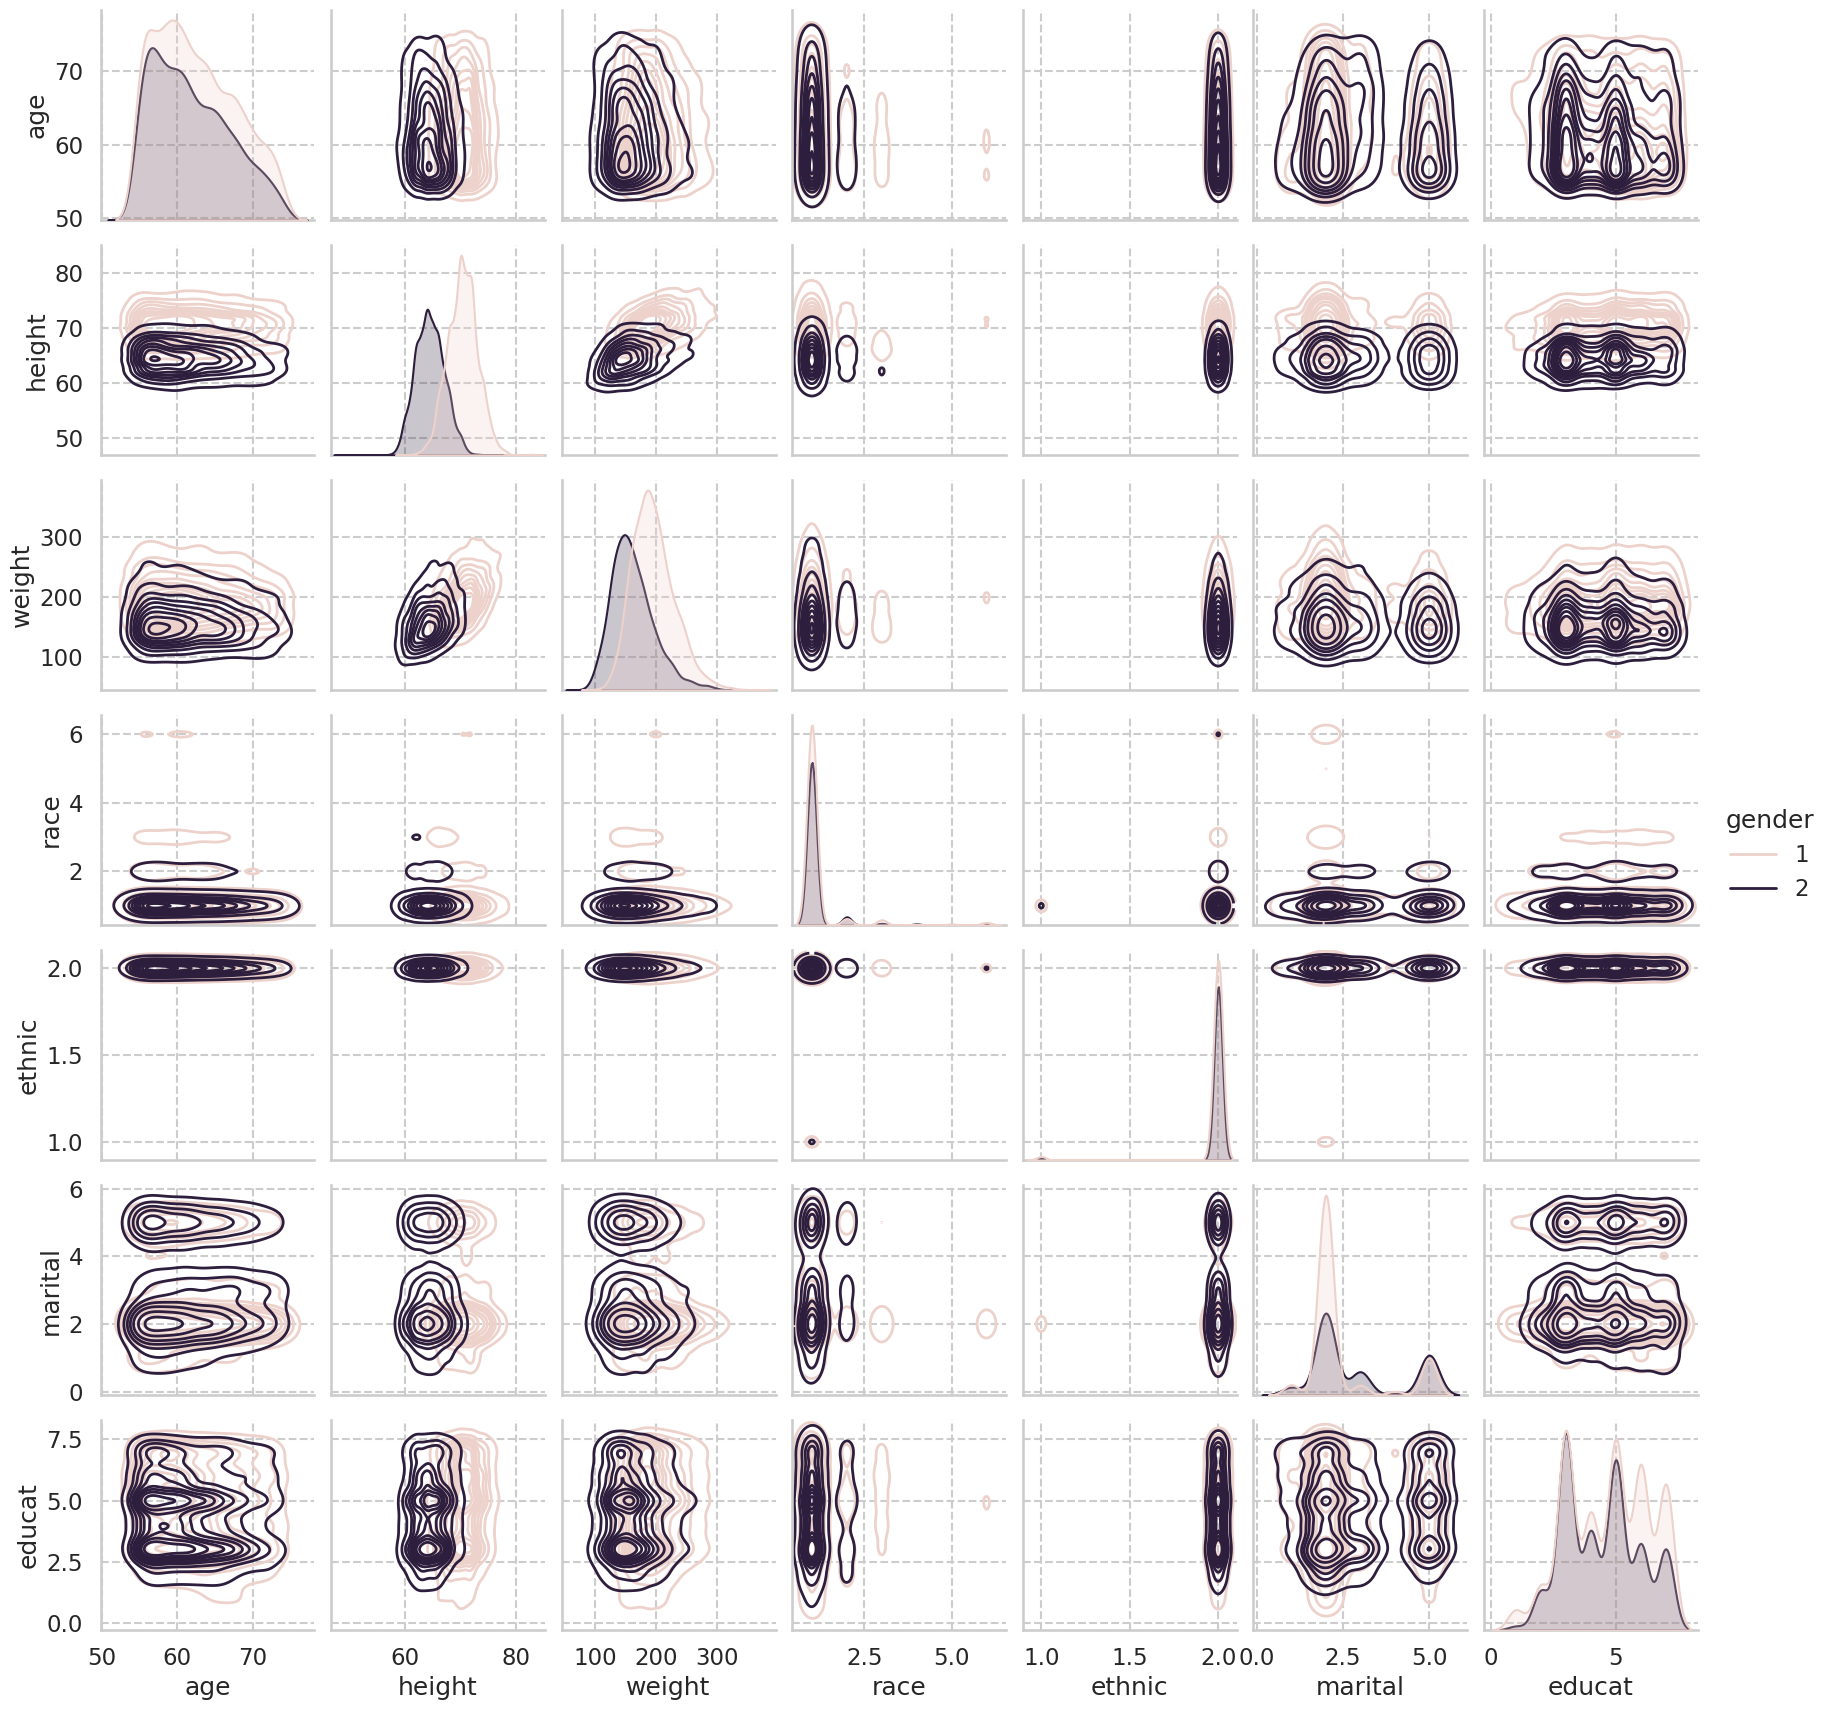

In [12]:
sns.pairplot(df[col_demo_num + col_demo_cat], hue='gender', kind='kde')

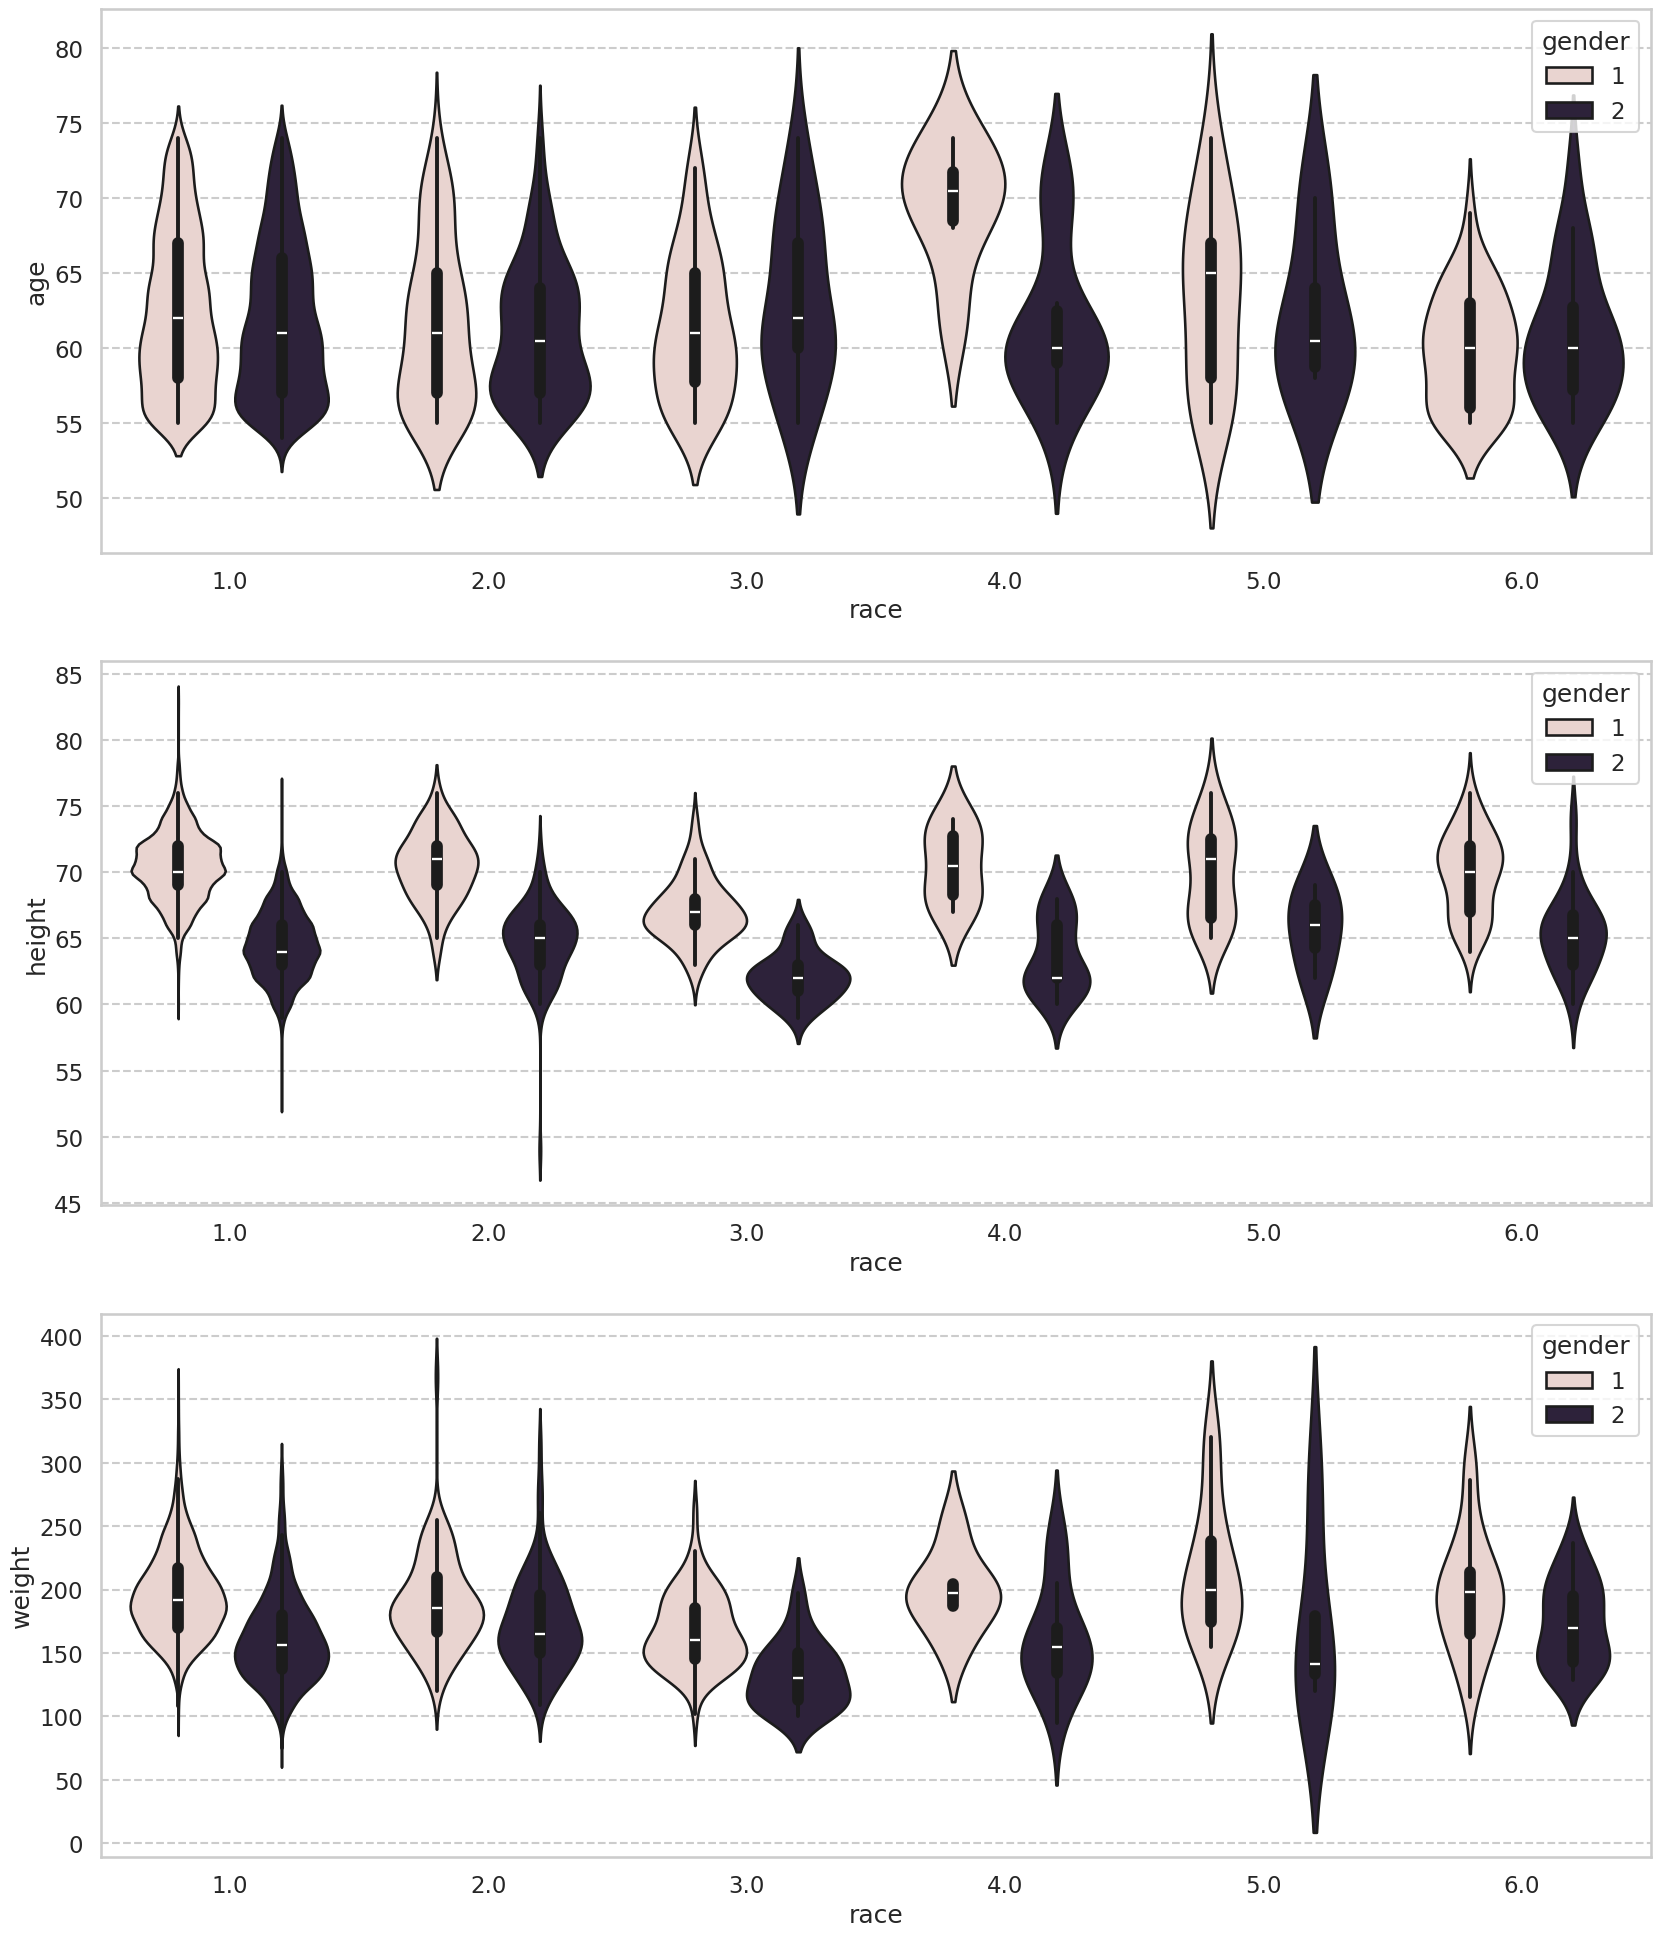

In [13]:
fig, ax = plt.subplots(3,1, figsize=(20,24))
for i, c, in enumerate(col_demo_num):
    sns.violinplot(ax=ax[i], data=df, x='race', y=c, hue='gender', inner='box')
plt.show()

Aggregate some of the columns into more useful binary columns.

Age and gender are already included in Kiran's sheet so we don't need it here as well.

In [ ]:
cols['cat']['demo'] = list(set(col_demo_cat) - set(['gender']))
cols['num']['demo'] = list(set(col_demo_num) - set(['age']))

### Smoking columns

In [15]:
col_smoke_cat =  ['cigar', 'cigsmok', 'pipe', 'smokelive', 'smokework']
col_smoke_num = ['age_quit', 'pkyr', 'smokeage', 'smokeday', 'smokeyr']
df[col_smoke_cat + col_smoke_num].isna().sum()

cigar          18
cigsmok         0
pipe           35
smokelive      23
smokework      35
age_quit     2664
pkyr            0
smokeage        0
smokeday        0
smokeyr         0
dtype: int64

Let's not include `age_quit`.

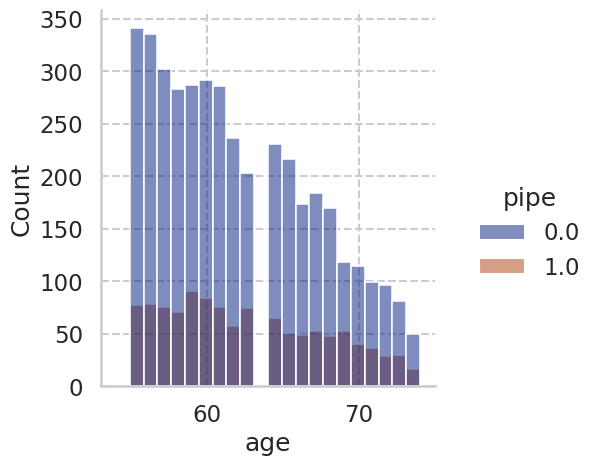

In [16]:
sns.displot(df, x='age', hue='pipe')

In [17]:
pd.DataFrame({c: df[c].value_counts(dropna=False) for c in col_smoke_cat}).drop_duplicates()

,cigar,cigsmok,pipe,smokelive,smokework
0.0,4242,2621.0,4097,614,675
1.0,1022,2661.0,1150,4645,4572
NaN,18,NaN,35,23,35


In [18]:
pd.DataFrame({c: [len(df.query(f'gender == {i} and {c} == 1')) for i in [1,2]] for c in col_smoke_cat}, index=['M','F'])

,cigar,cigsmok,pipe,smokelive,smokework
M,942,1495,1107,2520,2665
F,80,1166,43,2125,1907


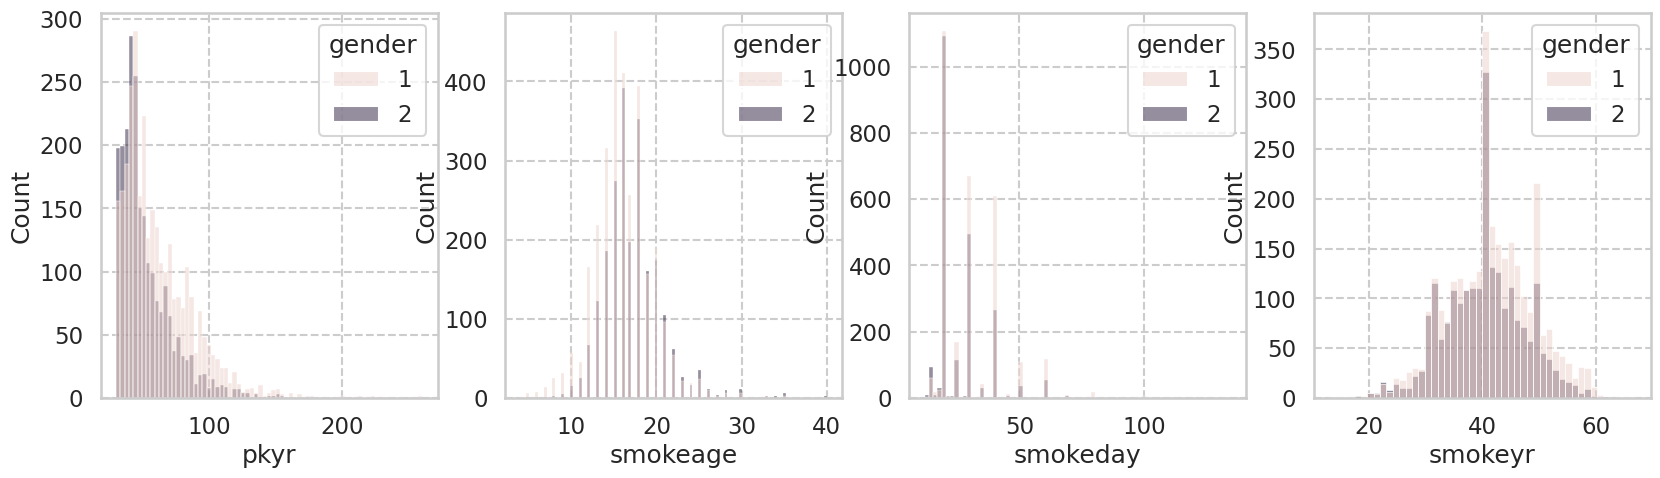

In [19]:
col_smoke_num = ['pkyr', 'smokeage', 'smokeday', 'smokeyr']
fig, ax = plt.subplots(1, len(col_smoke_num), figsize=(5*len(col_smoke_num), 5))
for i, c in enumerate(col_smoke_num):
    sns.histplot(data=df, x=c, ax=ax[i], hue='gender')
plt.show()

In [20]:
cols['cat']['smoke'] = col_smoke_cat
cols['num']['smoke'] = col_smoke_num

### Work history columns

In [21]:
workfacets = ['res', 'wrk', 'yrs']
worktypes = ['asbe', 'baki', 'butc', 'chem', 'coal', 'cott', 'farm', 'fire', 'flou', 'foun', 'hard', 'pain', 'sand', 'weld']
workcols = {f: [f+t for t in worktypes] for f in workfacets}

In [22]:
for t in worktypes:
    hasworked = len(df.query(f'wrk{t} == 1'))
    resnotnull = len(df[~df[f'res{t}'].isna()])
    yrsnotnull = len(df[~df[f'yrs{t}'].isna()])
    print(t, hasworked, resnotnull, yrsnotnull)

asbe 253 246 240
baki 133 132 127
butc 111 109 110
chem 352 333 343
coal 27 26 26
cott 43 41 42
farm 591 566 578
fire 95 93 93
flou 54 53 54
foun 229 219 222
hard 36 34 36
pain 282 274 272
sand 95 90 88
weld 297 287 290


In [23]:
df[workcols['wrk']].sum(axis=1).sort_values(ascending=False)

3427    12.0
3121     8.0
3602     8.0
2343     7.0
1908     7.0
        ... 
2052     0.0
2054     0.0
2056     0.0
2057     0.0
2641     0.0
Length: 5282, dtype: float64

In [24]:
pd.DataFrame({t: df[f'wrk{t}'].value_counts(dropna=False) for t in worktypes})

,asbe,baki,butc,chem,coal,cott,farm,fire,flou,foun,hard,pain,sand,weld
0.0,5024,5148,5170,4927,5254,5238,4689,5186,5227,5052,5245,4999,5186,4984
1.0,253,133,111,352,27,43,591,95,54,229,36,282,95,297
NaN,5,1,1,3,1,1,2,1,1,1,1,1,1,1


In [25]:
pd.DataFrame({t: [len(df.query(f'gender == {i} and wrk{t} == 1')) for i in [1,2]] for t in worktypes}, index=['M','F'])

,asbe,baki,butc,chem,coal,cott,farm,fire,flou,foun,hard,pain,sand,weld
M,234,73,93,235,26,30,454,92,45,210,35,235,82,275
F,19,60,18,117,1,13,137,3,9,19,1,47,13,22


In [26]:
pd.DataFrame({t: df[f'res{t}'].value_counts(dropna=False) for t in worktypes}).drop_duplicates()

,asbe,baki,butc,chem,coal,cott,farm,fire,flou,foun,hard,pain,sand,weld
NaN,5036,5150.0,5173.0,4949,5256,5241.0,4716,5189,5229,5063,5248,5008,5192,4995
0.0,205,131.0,107.0,277,22,39.0,549,45,47,190,28,201,41,235
1.0,36,1.0,2.0,51,2,2.0,15,45,5,26,5,69,48,51
2.0,5,NaN,NaN,5,2,NaN,2,3,1,3,1,4,1,1


In [27]:
for t in worktypes:
    nomask = df[f'res{t}'] == 0
    df[f'wrknomask{t}'] = nomask

df['wrknomask'] = df[[f'wrknomask{t}' for t in worktypes]].any(axis=1)

In [28]:
pd.DataFrame({t: [len(df.query(f'gender == {i} and wrknomask{t} == 1')) for i in [1,2]] for t in worktypes}, index=['M','F'])

,asbe,baki,butc,chem,coal,cott,farm,fire,flou,foun,hard,pain,sand,weld
M,188,72,91,180,21,26,426,44,40,173,28,162,33,219
F,17,59,16,97,1,13,123,1,7,17,0,39,8,16


In [29]:
df['wrknomask'].value_counts()

wrknomask
False    3959
True     1323
Name: count, dtype: int64

In [30]:
df[workcols['res']].iloc[3156]

resasbe    NaN
resbaki    NaN
resbutc    NaN
reschem    NaN
rescoal    NaN
rescott    NaN
resfarm    0.0
resfire    NaN
resflou    NaN
resfoun    NaN
reshard    NaN
respain    2.0
ressand    NaN
resweld    NaN
Name: 3156, dtype: float64

In [31]:
df[workcols['yrs']].describe()

,yrsasbe,yrsbaki,yrsbutc,yrschem,yrscoal,yrscott,yrsfarm,yrsfire,yrsflou,yrsfoun,yrshard,yrspain,yrssand,yrsweld
count,240.000000,127.000000,110.000000,343.000000,26.000000,42.000000,578.000000,93.000000,54.000000,222.000000,36.000000,272.000000,88.000000,290.000000
mean,14.741667,8.259843,9.827273,13.087464,16.076923,7.571429,13.043253,14.752688,9.148148,13.909910,10.277778,10.448529,10.920455,14.420690
std,13.258609,10.830742,11.739418,12.162806,13.962587,9.625025,10.545430,10.478400,11.296029,13.636556,10.188540,11.427822,10.875705,12.957834
min,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,3.000000,2.000000,2.000000,2.000000,2.250000,1.000000,5.000000,5.000000,2.000000,3.000000,2.000000,2.000000,2.000000,3.000000
50%,10.000000,3.000000,4.000000,8.000000,16.500000,4.000000,10.000000,12.000000,4.000000,8.000000,6.500000,5.000000,7.500000,10.000000
75%,25.000000,10.000000,14.750000,22.000000,24.500000,7.750000,18.000000,24.000000,9.750000,23.750000,15.250000,15.000000,18.000000,25.000000
max,50.000000,50.000000,50.000000,50.000000,55.000000,40.000000,60.000000,38.000000,47.000000,47.000000,38.000000,50.000000,50.000000,50.000000


<Axes: >

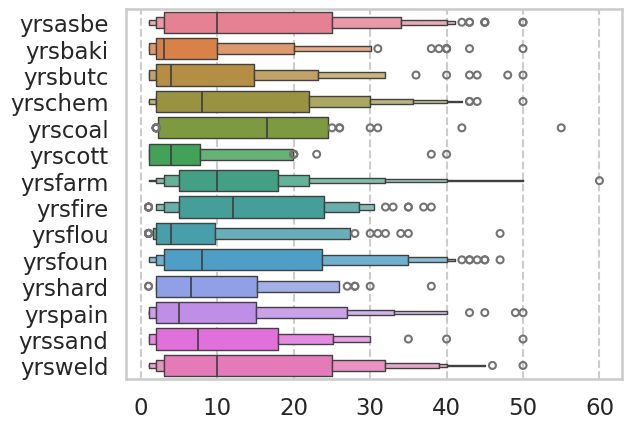

In [32]:
sns.boxenplot(data=df[workcols['yrs']], orient='h')

In [33]:
cols['cat']['work'] = workcols['wrk'] + ['wrknomask']

### Disease history columns

In [34]:
diseasefacets = ['age', 'diag']
diseasetypes = ['adas', 'asbe', 'bron', 'chas', 'chro', 'copd', 'diab', 'emph', 'fibr', 'hear', 'hype', 'pneu', 'sarc', 'sili', 'stro', 'tube']

In [35]:
pd.DataFrame({t: df[f'diag{t}'].value_counts(dropna=False) for t in diseasetypes}).drop_duplicates()

,adas,asbe,bron,chas,chro,copd,diab,emph,fibr,hear,hype,pneu,sarc,sili,stro,tube
0.0,4920,5218,5084,5097,4705,4905,4758,4723,5257,4556,3396,4031,5256,5260,5124,5216
1.0,353,57,181,178,561,358,518,546,16,706,1876,1240,13,9,152,60
NaN,9,7,17,7,16,19,6,13,9,20,10,11,13,13,6,6


In [36]:
pd.DataFrame({t: [len(df.query(f'gender == {i} and diag{t} == 1')) for i in [1,2]] for t in diseasetypes}, index=['M','F'])

,adas,asbe,bron,chas,chro,copd,diab,emph,fibr,hear,hype,pneu,sarc,sili,stro,tube
M,111,55,89,104,203,177,341,338,10,521,1123,580,6,7,99,34
F,242,2,92,74,358,181,177,208,6,185,753,660,7,2,53,26


In [37]:
emph_check_preds = nlst_preds[['Emphysema', 'PatientID']].drop_duplicates()
emph_check_preds

,Emphysema,PatientID
0,False,100012
2,True,100019
3,True,100035
6,False,100040
8,False,100053
...,...,...
16066,True,218860
16069,False,218862
16072,False,218863
16075,False,218866


In [38]:
emph_check_preds['PatientID'].value_counts()

PatientID
133114    2
108133    2
211539    2
121868    2
121846    2
         ..
119068    1
119062    1
119061    1
119056    1
218887    1
Name: count, Length: 5282, dtype: int64

In [39]:
nlst_preds[['Emphysema', 'PatientID']].drop_duplicates(subset=['PatientID'])

,Emphysema,PatientID
0,False,100012
2,True,100019
3,True,100035
6,False,100040
8,False,100053
...,...,...
16066,True,218860
16069,False,218862
16072,False,218863
16075,False,218866


In [40]:
df_emph_check = df[['pid','diagemph', 'ageemph']]
df_emph_check = df_emph_check.merge(nlst_preds[['Emphysema', 'PatientID']].drop_duplicates(subset=['PatientID']), left_on='pid', right_on='PatientID', how='left').drop_duplicates()
df_emph_check

,pid,diagemph,ageemph,Emphysema,PatientID
0,100012,0.0,NaN,False,100012
1,100019,1.0,60.0,True,100019
2,100035,0.0,NaN,True,100035
3,100040,0.0,NaN,False,100040
4,100053,0.0,NaN,False,100053
...,...,...,...,...,...
5277,218860,0.0,NaN,True,218860
5278,218862,0.0,NaN,False,218862
5279,218863,1.0,54.0,False,218863
5280,218866,0.0,NaN,False,218866


In [41]:
df[[f"age{t}" for t in diseasetypes]].describe()

,ageadas,ageasbe,agebron,agechas,agechro,agecopd,agediab,ageemph,agefibr,agehear,agehype,agepneu,agesarc,agesili,agestro,agetube
count,344.000000,56.000000,151.000000,164.000000,511.000000,339.000000,504.000000,513.000000,15.000000,677.000000,1810.000000,1149.000000,13.000000,9.000000,147.000000,58.000000
mean,49.976744,54.642857,38.357616,6.646341,40.927593,56.982301,54.438492,56.116959,50.866667,54.355982,51.765746,35.375109,48.153846,53.555556,57.455782,28.465517
std,12.838741,7.354476,19.412829,3.939331,17.123446,7.469443,9.963561,8.926455,9.804275,10.431178,10.868191,20.112604,18.045526,12.875472,8.327403,18.714115
min,13.000000,27.000000,1.000000,0.000000,1.000000,30.000000,1.000000,13.000000,25.000000,1.000000,3.000000,1.000000,8.000000,30.000000,21.000000,0.000000
25%,42.750000,50.000000,21.000000,4.000000,30.000000,52.500000,50.000000,51.000000,49.000000,50.000000,46.000000,18.000000,39.000000,54.000000,54.000000,12.750000
50%,53.000000,56.500000,40.000000,6.000000,45.000000,57.000000,56.000000,57.000000,51.000000,56.000000,54.000000,35.000000,54.000000,57.000000,59.000000,25.000000
75%,60.000000,60.000000,55.000000,9.000000,55.000000,62.000000,60.000000,62.000000,56.000000,61.000000,60.000000,54.000000,61.000000,62.000000,62.000000,41.500000
max,72.000000,65.000000,73.000000,17.000000,72.000000,73.000000,73.000000,73.000000,65.000000,74.000000,73.000000,74.000000,69.000000,65.000000,73.000000,68.000000


<Axes: >

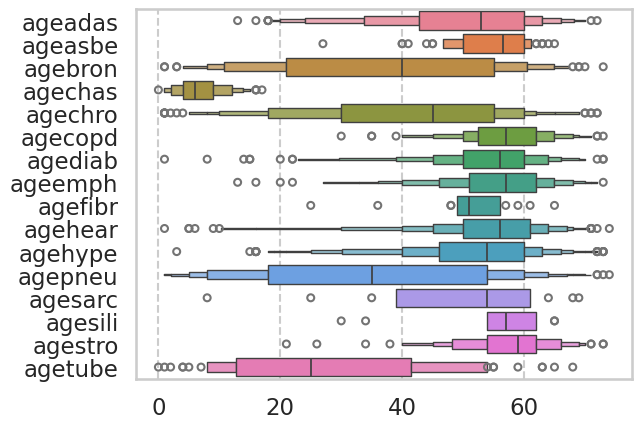

In [42]:
sns.boxenplot(data=df[[f"age{t}" for t in diseasetypes]], orient='h')

In [43]:
cols['cat']['disease'] = [f'diag{t}' for t in diseasetypes]

### Personal cancer history columns

In [44]:
pcancerfacets = ['age', 'canc']
pcancertypes = ['blad', 'brea', 'cerv', 'colo', 'esop', 'kidn', 'lary', 'lung', 'nasa', 'oral', 'panc', 'phar', 'stom', 'thyr', 'tran']

In [45]:
pd.DataFrame({t: df[f'canc{t}'].value_counts(dropna=False) for t in pcancertypes}).drop_duplicates()

,blad,brea,cerv,colo,esop,kidn,lary,lung,nasa,oral,panc,phar,stom,thyr,tran
0.0,5240,5182,5197,5251,5271,5268,5271,5272,5271,5261,5276.0,5275,5270,5265,5271
1.0,35,91,78,25,5,8,5,4,3,14,NaN,1,6,8,1
NaN,7,9,7,6,6,6,6,6,8,7,6.0,6,6,9,10


In [46]:
pd.DataFrame({t: [len(df.query(f'gender == {i} and canc{t} == 1')) for i in [1,2]] for t in pcancertypes}, index=['M','F'])

,blad,brea,cerv,colo,esop,kidn,lary,lung,nasa,oral,panc,phar,stom,thyr,tran
M,31,0,0,14,4,4,5,3,2,9,0,0,4,5,0
F,4,91,78,11,1,4,0,1,1,5,0,1,2,3,1


In [47]:
df[[f"age{t}" for t in pcancertypes]].describe()

,ageblad,agebrea,agecerv,agecolo,ageesop,agekidn,agelary,agelung,agenasa,ageoral,agepanc,agephar,agestom,agethyr,agetran
count,35.000000,91.000000,78.000000,25.000000,5.000000,8.000000,5.000000,4.00,3.000000,14.000000,0.0,1.0,6.000000,8.000000,1.0
mean,55.885714,49.626374,36.538462,53.840000,50.800000,54.625000,55.000000,65.25,62.000000,53.928571,NaN,54.0,47.000000,45.375000,45.0
std,10.303544,8.452019,10.079801,8.979978,6.978539,7.424621,12.629331,4.50,6.244998,9.988180,NaN,NaN,7.071068,11.987345,NaN
min,17.000000,25.000000,21.000000,32.000000,45.000000,48.000000,40.000000,59.00,55.000000,36.000000,NaN,54.0,35.000000,30.000000,45.0
25%,52.000000,43.500000,28.000000,50.000000,46.000000,49.500000,43.000000,63.50,59.500000,50.000000,NaN,54.0,45.000000,36.250000,45.0
50%,56.000000,50.000000,34.500000,55.000000,48.000000,52.000000,60.000000,66.50,64.000000,54.000000,NaN,54.0,47.500000,43.000000,45.0
75%,63.500000,55.500000,41.750000,59.000000,53.000000,57.500000,65.000000,68.25,65.500000,60.750000,NaN,54.0,51.500000,56.250000,45.0
max,68.000000,68.000000,63.000000,67.000000,62.000000,67.000000,67.000000,69.00,67.000000,70.000000,NaN,54.0,55.000000,61.000000,45.0


<Axes: >

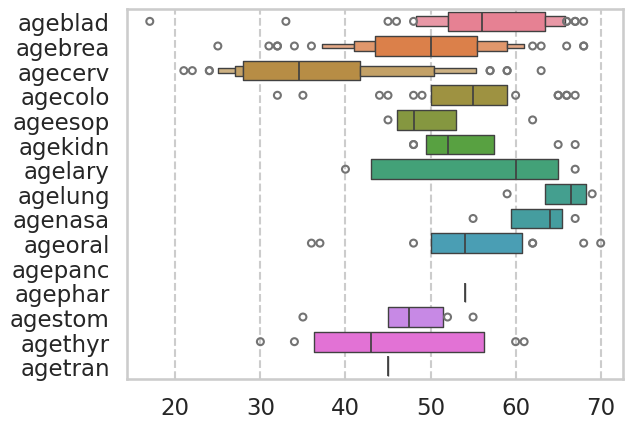

In [48]:
sns.boxenplot(data=df[[f"age{t}" for t in pcancertypes]], orient='h')

In [49]:
cols['cat']['canchist'] = [f"canc{t}" for t in pcancertypes]

### Family history Lung cancer columns
Unused because it doesn't match with existing `FamilyHistoryLungCa` column.

In [50]:
relatives = ['brother', 'sister', 'child', 'father', 'mother']
col_famhist = ['fam'+member for member in relatives]
pd.DataFrame({t: df[f'fam{t}'].value_counts(dropna=False) for t in relatives}).drop_duplicates()

,brother,sister,child,father,mother
0.0,4842,4920,5113,4552,4813
1.0,298,221,25,562,339
NaN,142,141,144,168,130


In [51]:
df['famhist'] = df[col_famhist].any(axis=1)
df_famhist = df[['pid', 'famhist']].set_index('pid')
df_famhist

,famhist
pid,
100012,False
100019,False
100035,False
100040,False
100053,False
...,...
218860,False
218862,False
218863,True


In [52]:
pred_famhist = nlst_preds[['PatientID', 'FamilyHistoryLungCa']].drop_duplicates().reset_index(drop=True).set_index('PatientID')
pred_famhist.index.names = ['pid']
pred_famhist.rename(columns={'FamilyHistoryLungCa': 'famhist'}, inplace=True)
pred_famhist

,famhist
pid,
100012,True
100019,False
100035,False
100040,False
100053,False
...,...
218860,False
218862,False
218863,True


In [53]:
df_famhist.compare(pred_famhist)

famhist      
          self other
pid                 
100012   False  True
100517   False  True
100877   False  True
101873   False  True
102093   False  True
...        ...   ...
217793   False  True
217982   False  True
218238   False  True
218414   False  True
218800   False  True

[165 rows x 2 columns]

In [54]:
nlst_preds[['PatientID', 'FamilyHistoryLungCa']].drop_duplicates()['FamilyHistoryLungCa'].value_counts(dropna=False)

FamilyHistoryLungCa
False    3905
True     1377
Name: count, dtype: int64

### Alcohol columns

In [55]:
alcohol_acrin = ['acrin_alc_curr', 'acrin_alc_ever', 'acrin_drink24hr', 'acrin_drinknum_curr', 'acrin_drinknum_form', 'acrin_drinkyrs_curr', 'acrin_drinkyrs_form', 'acrin_lastdrink']
alcohol_lss = ['lss_alcohol_freq', 'lss_alcohol_num']

In [56]:
df['study'].value_counts() #1 is LSS, 2 and 3 are ACRIN

study
1    3518
2    1023
3     741
Name: count, dtype: int64

In [57]:
df['acrin_alc_curr'].value_counts(dropna=False)

acrin_alc_curr
NaN    3620
2.0    1225
1.0     437
Name: count, dtype: int64

In [58]:
df['lss_alcohol_freq'].value_counts(dropna=False)

lss_alcohol_freq
NaN    1787
2.0     876
5.0     804
1.0     722
3.0     619
4.0     474
Name: count, dtype: int64

In [59]:
df[alcohol_acrin + alcohol_lss].describe()

,acrin_alc_curr,acrin_alc_ever,acrin_drink24hr,acrin_drinknum_curr,acrin_drinknum_form,acrin_drinkyrs_curr,acrin_drinkyrs_form,acrin_lastdrink,lss_alcohol_freq,lss_alcohol_num
count,1662.000000,1757.000000,1185.000000,1181.000000,404.000000,1174.000000,405.000000,435.000000,3495.000000,2744.000000
mean,1.737064,1.948776,0.972152,6.938188,13.975248,39.326235,23.711111,2.372414,2.931903,1.910350
std,0.440361,0.220516,1.622811,9.341564,20.147949,10.454303,13.555825,0.860914,1.459018,0.912094
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
25%,1.000000,2.000000,0.000000,0.000000,0.000000,35.000000,12.000000,1.000000,2.000000,1.000000
50%,2.000000,2.000000,0.000000,4.000000,5.000000,40.000000,23.000000,3.000000,3.000000,2.000000
75%,2.000000,2.000000,2.000000,10.000000,20.000000,45.000000,34.000000,3.000000,4.000000,2.000000
max,2.000000,2.000000,26.000000,89.000000,100.000000,70.000000,70.000000,3.000000,5.000000,5.000000


I don't know how to aggregate these columns, if I'm gonna be honest.

## Aggregate Columns

In [60]:
cols
## Not sure yet about:
## - alcohol history
## emphysema?????

{'num': {'demo': ['height', 'weight'],
  'smoke': ['pkyr', 'smokeage', 'smokeday', 'smokeyr']},
 'cat': {'demo': ['marital', 'educat', 'race', 'ethnic'],
  'smoke': ['cigar', 'cigsmok', 'pipe', 'smokelive', 'smokework'],
  'work': ['wrkasbe',
   'wrkbaki',
   'wrkbutc',
   'wrkchem',
   'wrkcoal',
   'wrkcott',
   'wrkfarm',
   'wrkfire',
   'wrkflou',
   'wrkfoun',
   'wrkhard',
   'wrkpain',
   'wrksand',
   'wrkweld',
   'wrknomask'],
  'disease': ['diagadas',
   'diagasbe',
   'diagbron',
   'diagchas',
   'diagchro',
   'diagcopd',
   'diagdiab',
   'diagemph',
   'diagfibr',
   'diaghear',
   'diaghype',
   'diagpneu',
   'diagsarc',
   'diagsili',
   'diagstro',
   'diagtube'],
  'canchist': ['cancblad',
   'cancbrea',
   'canccerv',
   'canccolo',
   'cancesop',
   'canckidn',
   'canclary',
   'canclung',
   'cancnasa',
   'cancoral',
   'cancpanc',
   'cancphar',
   'cancstom',
   'cancthyr',
   'canctran']},
 'info': ['PatientID', 'study']}

In [61]:
cols_num = sum(cols['num'].values(), start=[])
cols_cat = sum(cols['cat'].values(), start=[])
cols_list = cols_num + cols_cat + cols['info']
len(cols_list)

63

In [62]:
for c in cols_cat:
    print(df[c].value_counts(dropna=False))

marital
2.0    3507
5.0    1014
3.0     454
1.0     233
4.0      62
NaN      12
Name: count, dtype: int64
educat
3.0    1324
5.0    1201
6.0     833
7.0     757
4.0     711
2.0     276
NaN      99
1.0      81
Name: count, dtype: int64
race
1.0    4882
2.0     195
3.0      93
6.0      59
4.0      20
5.0      19
NaN      14
Name: count, dtype: int64
ethnic
2.0    5170
1.0      79
NaN      33
Name: count, dtype: int64
cigar
0.0    4242
1.0    1022
NaN      18
Name: count, dtype: int64
cigsmok
1    2661
0    2621
Name: count, dtype: int64
pipe
0.0    4097
1.0    1150
NaN      35
Name: count, dtype: int64
smokelive
1.0    4645
0.0     614
NaN      23
Name: count, dtype: int64
smokework
1.0    4572
0.0     675
NaN      35
Name: count, dtype: int64
wrkasbe
0.0    5024
1.0     253
NaN       5
Name: count, dtype: int64
wrkbaki
0.0    5148
1.0     133
NaN       1
Name: count, dtype: int64
wrkbutc
0.0    5170
1.0     111
NaN       1
Name: count, dtype: int64
wrkchem
0.0    4927
1.0     352
NaN   

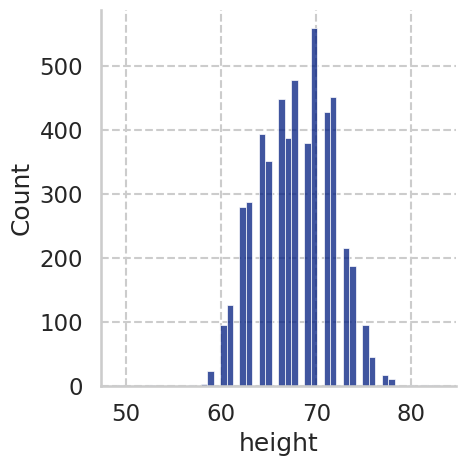

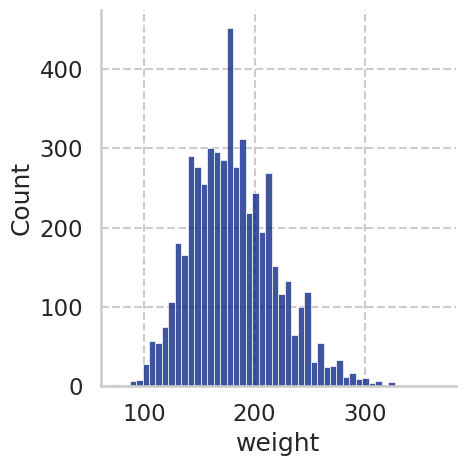

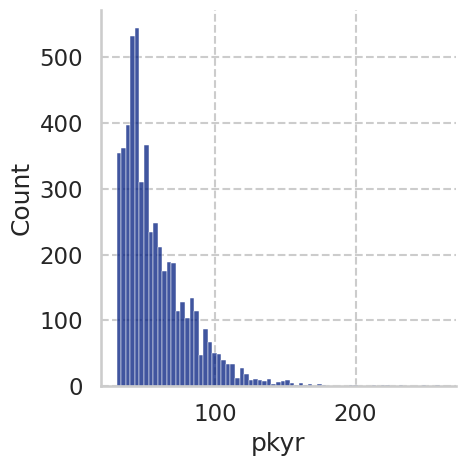

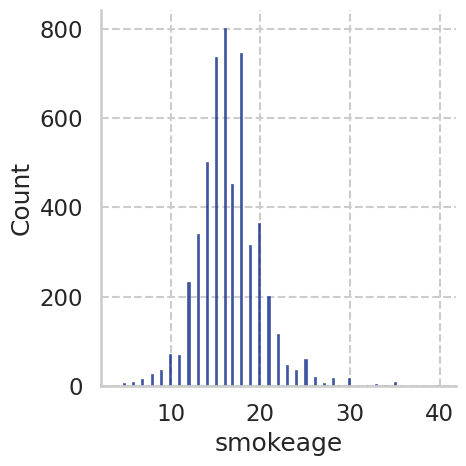

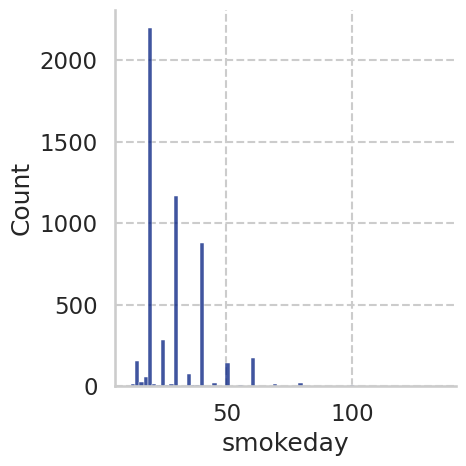

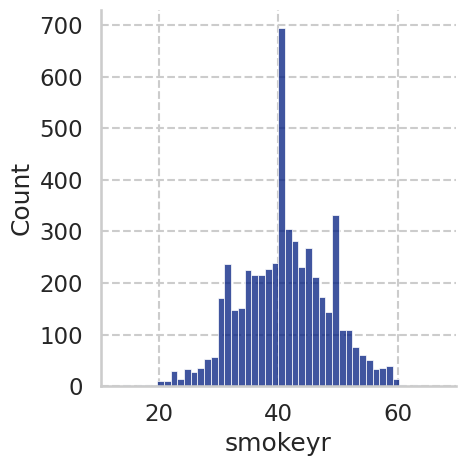

In [63]:
for c in cols_num:
    sns.displot(df, x=c)

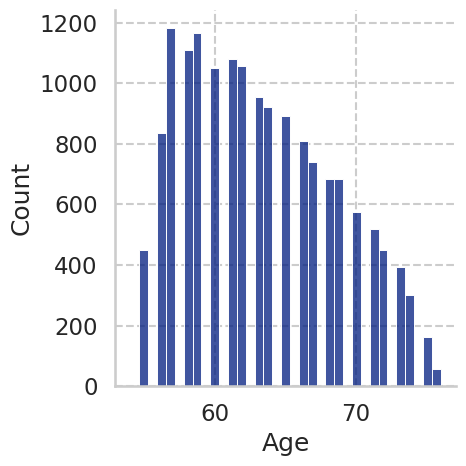

In [15]:
sns.displot(nlst_preds['Age'])

In [64]:
cols['cat']['demo'].append('Gender')
cols['num']['demo'].append('Age')
cols['cat']['canchist'].append('FamilyHistoryLungCa')

with open(f'{NLST_PREDS}/nlst_demo_v1_cols.json', 'w') as f:
    json.dump(cols, f)

In [65]:
df[cols_list].to_csv(f'{NLST_PREDS}/nlst_demo_v1.csv', index=False)

In [66]:
nlst_preds_demos = nlst_preds.merge(df[cols_list], on='PatientID', how='left')
nlst_preds_demos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16077 entries, 0 to 16076
Data columns (total 88 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   PatientID            16077 non-null  int64  
 1   StudyDate            16077 non-null  int64  
 2   SeriesInstanceUID    16077 non-null  object 
 3   CoordX               16077 non-null  float64
 4   CoordY               16077 non-null  float64
 5   CoordZ               16077 non-null  float64
 6   LesionID             16077 non-null  int64  
 7   NoduleType           16077 non-null  object 
 8   Spiculation          16077 non-null  bool   
 9   Diameter [mm]        16077 non-null  float64
 10  Age                  16077 non-null  int64  
 11  Gender               16077 non-null  int64  
 12  FamilyHistoryLungCa  16077 non-null  bool   
 13  Emphysema            16077 non-null  bool   
 14  NoduleInUpperLung    16077 non-null  bool   
 15  NoduleCounts         16077 non-null 

In [67]:
nlst_preds_demos

,PatientID,StudyDate,SeriesInstanceUID,CoordX,CoordY,CoordZ,LesionID,NoduleType,Spiculation,Diameter [mm],...,canclary,canclung,cancnasa,cancoral,cancpanc,cancphar,cancstom,cancthyr,canctran,study
0,100012,19990102,1.2.840.113654.2.55.24023112856488152536348979...,-32.919853,-136.22139,-90.400002,1,Solid,False,11.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,100012,20000102,1.2.840.113654.2.55.50761756412482430061802871...,-47.650000,-130.37000,1222.350000,1,PartSolid,False,23.4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,100019,20000102,1.2.840.113654.2.55.12567845460924968711329545...,-103.190000,74.01000,-1129.370000,1,Solid,False,10.6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,100035,19990102,1.2.840.113654.2.55.64360087057061878755830205...,124.670000,5.85000,-193.590000,1,Solid,False,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,100035,20000102,1.2.840.113654.2.55.33941066798745864774354503...,127.360000,-2.95000,-184.570000,1,Solid,False,4.8,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16072,218863,19990102,1.3.6.1.4.1.14519.5.2.1.7009.9004.977896926234...,-91.340000,-44.15000,-177.200000,1,GroundGlassOpacity,False,4.7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
16073,218863,19990102,1.3.6.1.4.1.14519.5.2.1.7009.9004.977896926234...,69.720000,-48.07000,-86.470000,2,SemiSolid,False,6.8,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
16074,218863,20010102,1.3.6.1.4.1.14519.5.2.1.7009.9004.796552648301...,61.210000,-7.69000,-15.050000,2,SemiSolid,False,7.6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
16075,218866,20000102,1.3.6.1.4.1.14519.5.2.1.7009.9004.698887010763...,31.260000,-216.76000,250.570000,1,Solid,False,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2


In [68]:
nlst_preds_demos.to_csv(f'{NLST_PREDS}/nlst_demo_v1_w3preds.csv', index=False)